In [1]:
import sys
sys.path.insert(0, '../tracing_analysis')
import navis
import pymaid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib
import pandas as pd
import pickle
from scipy import stats as stats
import analysis_dataframes as myDF
import ppc_analysis_functions.catmaid_API as cAPI
import ppc_analysis_functions.figure_plotting as figs

cwd = os.getcwd()
figsDir = os.sep.join([cwd,'fig_panels/'])
workingDir = os.sep.join([os.path.dirname(cwd), 'analysis_dataframes/'])

# Define LR colormap and make colorbar
pal = {'anti':'#ba48cf', 'co':'#2CB899'} # darker
order = ['anti','co']

In [2]:
# Supp. Table 2: Export table of I-to-E connections
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)

E2I_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'I-E']
E2I_cn_DF['pair_select_sign'] = np.sign(E2I_cn_DF.pair_select_idx)
E2I_cn_DF.dropna(subset=['pair_select_idx'], inplace=True)
pd.options.display.float_format = '{:.3f}'.format
E2I_cn_DF[['source','source_select_idx_new','target','target_select_idx','pair_select_idx_new','pair_select_idx_tmax_new','syn_count','cable_overlap','syn_den','avg_psd_area']].sort_values(by = ['pair_select_idx_new']).to_csv(figsDir+'I2E_table.csv',float_format='%.3g')

Max syn_count is 6
6
Co: n=1,  290.640 +- nan
Anti: n=0, nan +- nan
5
Co: n=0,  nan +- nan
Anti: n=1, 266.738 +- nan
4
Co: n=2,  157.205 +- 2.296
Anti: n=3, 230.900 +- 56.573
3
Co: n=5,  191.210 +- 20.656
Anti: n=3, 95.026 +- 36.452
2
Co: n=12,  166.930 +- 26.590
Anti: n=9, 113.366 +- 16.929
1
Co: n=43,  102.763 +- 8.961
Anti: n=34, 86.022 +- 11.531
0
Co: n=225,  53.131 +- 3.919
Anti: n=244, 46.787 +- 3.528
0.014550535394524368 0.021243466479192938


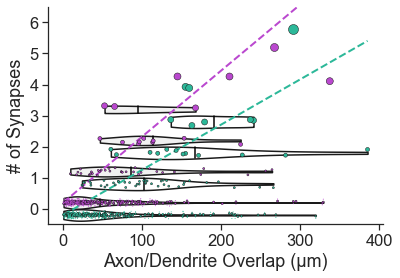

In [3]:
# ED Fig. 2a: Plot all connections and cable overlaps
dataset = 'PPC'
with open(workingDir + 'pot_dir_cn_DF_'+dataset+'.pkl' , 'rb') as f:  
    pot_cns = pickle.load(f)
def classify_syn_count(n):
    if n == 0:
        return '0'
    elif n > 0:
        return '>=1'
def classify_syn_count(n):
    return(str(int(n)))
I2E_pot_cns = pot_cns[pot_cns.cn_type == 'I-E']
I2E_pot_cns['pair_select_sign'] = ['co' if i>=0 else 'anti' for i in I2E_pot_cns.pair_select_idx_new]
I2E_pot_cns['pair_cn_count'] = [classify_syn_count(i) for i in I2E_pot_cns.syn_count]

order = ['6','5','4','3','2','1','0']
order_crop = ['3','2','1','0']

sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')

g=figs.my_violinplot(data = I2E_pot_cns[I2E_pot_cns.pair_cn_count.isin(order_crop)], y='pair_cn_count', x='cable_overlap', hue='pair_select_sign', scale='count', order=order,hue_order =['anti','co'], color='w')
sns.stripplot(data=I2E_pot_cns[I2E_pot_cns.syn_count == 0], y='pair_cn_count', x='cable_overlap', hue='pair_select_sign', edgecolor='k', linewidth=0.5, dodge=True,s=2,order=order, palette = pal,hue_order = ['anti','co'])
print('Max syn_count is %i' % np.max(I2E_pot_cns.syn_count.values))

#  Plot each pair with markers and size based on # of synapses
syn_counts = np.arange(int(np.max(I2E_pot_cns.syn_count.values)+1))
markers = ['.','.','.','.','.','.','.']
w = [0,.5, .5, .5, .5,.5, .5]
sizes = [2,4,8,12,14,16,20]
for c in syn_counts:
    my_data = I2E_pot_cns[I2E_pot_cns.syn_count == c]
    if len(my_data) > 0:
        sns.stripplot(data=my_data, y='pair_cn_count', x='cable_overlap', hue='pair_select_sign', edgecolor='k',jitter=.25,linewidth=w[c],s=sizes[c], marker=markers[c], dodge=True,order=order, hue_order = ['anti','co'], palette = pal, ax=g)
plt.ylabel('# of Synapses')
plt.xlabel('Axon/Dendrite Overlap (µm)')
g.get_legend().remove()
sns.despine()

for cat in order:
    print(cat)
    cat_df = I2E_pot_cns[I2E_pot_cns.pair_cn_count == cat]
    same = cat_df[cat_df.pair_select_sign == 'co'].cable_overlap.values
    opp = cat_df[cat_df.pair_select_sign == 'anti'].cable_overlap.values

    print('Co: n=%i,  %.03f +- %.03f' % (len(same), np.mean(same), stats.sem(same)))
    print('Anti: n=%i, %.03f +- %.03f' % (len(opp), np.mean(opp), stats.sem(opp)))

with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
    dir_cn_DF= pickle.load(f)
I2E_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'I-E']
same_slp = np.mean(I2E_cn_DF[I2E_cn_DF.pair_select_idx>0].syn_den.values)
opp_slp = np.mean(I2E_cn_DF[I2E_cn_DF.pair_select_idx<0].syn_den.values)
print(same_slp, opp_slp)

same_max = np.max(I2E_cn_DF[I2E_cn_DF.pair_select_idx>0].cable_overlap.values)
opp_max = np.max(I2E_cn_DF[I2E_cn_DF.pair_select_idx<0].cable_overlap.values)
plt.plot([0,same_max],6-np.array([0, same_max*same_slp])+.2,'--', linewidth = 2, color = pal['co']) # y axis is inverted , correct for hue shift
plt.plot([0,opp_max],6-np.array([0, opp_max*opp_slp])-.2,'--',linewidth = 2, color = pal['anti']) # y axis is inverted , correct for hue shift
plt.ylim(6.5,-.5)
plt.savefig(figsDir+'I2E_cable_overlaps_'+dataset+'.pdf',bbox_inches='tight')

Overlap Threshold: 75.705
0.009000000000000001 0.012999999999999972 0.02199999999999997
p_value for permutation test: 0.022
co: n = 112, c = 0.00961 +- 0.00029
anti: n = 99, c = 0.01086 +- 0.00045


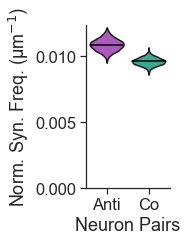

In [4]:
# ED Fig. 2b: Plot co/anti select freq including non-connects
# Edit to bootstrap only non-connects and include only non-connects with 
# overlap greater than avg overlap for 1 synapse
# estimate upper bound of syn freq for non-connects

with open(workingDir + 'pot_dir_cn_DF_PPC.pkl' , 'rb') as f:  
    pot_cns = pickle.load(f)
importlib.reload(myDF)
I2E_pot_cns = pot_cns[pot_cns.cn_type == 'I-E']

I2E_pot_cns.dropna(subset = ['pair_select_idx_new'])
I2E_pot_cns['pair_select_sign'] = ['co' if i>=0 else 'anti' for i in I2E_pot_cns.pair_select_idx_new]

I2E_cns = I2E_pot_cns[I2E_pot_cns.syn_count > 0] # I2E_cns is connected pairs
cn_syn_freq_df = myDF.calc_syn_freq_totals(I2E_cns)

overlap_thresh = 1/cn_syn_freq_df.freq_all.values[0] # average path length needed for 1 synapse
print('Overlap Threshold: %0.3f' % overlap_thresh)

I2E_non = I2E_pot_cns[I2E_pot_cns.syn_count == 0] # I2E_non is non-connected pairs
I2E_non = I2E_non[I2E_non.cable_overlap >= overlap_thresh] # only include non-connects with overlap beyond thresh
I2E_non['syn_count'] = 1 # calculate upper bound of syn freq by counting 1 syn per pair
non_syn_freq_df = myDF.calc_syn_freq_totals(I2E_non, shuf=False)

all_pot_cns = pd.concat([I2E_cns, I2E_non]) # Pool connected and upper bound syn freq estimate from non-connected
syn_freq_df_all = myDF.calc_syn_freq_totals(all_pot_cns)

n_shuf = 2000
syn_freq_df_boot = pd.DataFrame()
for n_shuf in range(n_shuf):
    I2E_non_boot = I2E_non.sample(frac=1, replace=True)
    all_pot_cns_boot = pd.concat([I2E_cns, I2E_non_boot]) # bootstrap over non-connected pairs only

    df_boot = myDF.calc_syn_freq_totals(all_pot_cns_boot)
    syn_freq_df_boot = pd.concat([syn_freq_df_boot, df_boot])

boot_plt_df = pd.DataFrame()
for i in ['co', 'anti']:
    df = pd.DataFrame()
    df['freq'] = syn_freq_df_boot['freq_'+i]
    df['pair_select'] = i
    boot_plt_df = pd.concat([boot_plt_df, df])
boot_plt_df

sns.set(rc={'figure.figsize':(1.5,3)}, font_scale=1.5, style='ticks')
order = ['anti', 'co']
g=figs.my_violinplot(data = boot_plt_df, x = 'pair_select', y='freq', palette = pal, order = order, scale='width')
g.set_ylim([0,g.get_ylim()[1]])
g.set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')
g.set_xlabel('Neuron Pairs')
g.set_xticklabels(['Anti', 'Co'])
sns.despine()

# Calculate p-value of difference between co and anti being different from 0, 
# bootstrapping over non-connected neurons.
p1 = stats.percentileofscore(syn_freq_df_all.freq_diff[0]-syn_freq_df_boot.freq_diff, syn_freq_df_all.freq_diff[0])
p2 = stats.percentileofscore(syn_freq_df_all.freq_diff[0]-syn_freq_df_boot.freq_diff, -syn_freq_df_all.freq_diff[0])

p_score1 = np.minimum(p1, 100-p1)/100
p_score2 = np.minimum(p2, 100-p2)/100
p_value = p_score1 + p_score2
print(p_score1, p_score2, p_value)

print('p_value for permutation test: %0.3f' % p_value)
print('co: n = %i, c = %0.5f +- %0.5f' % (sum(all_pot_cns.pair_select_sign == 'co'), syn_freq_df_all['freq_co'].values[0], np.std(syn_freq_df_boot.freq_co)))
print('anti: n = %i, c = %0.5f +- %0.5f' % (sum(all_pot_cns.pair_select_sign == 'anti'), syn_freq_df_all['freq_anti'].values[0], np.std(syn_freq_df_boot.freq_anti)))

plt.savefig(figsDir+'I2E_co-anti_freq_with_nonconnects.pdf',bbox_inches='tight')

[]
[ 3.16227766  3.83118685  4.64158883  5.62341325  6.81292069  8.25404185
 10.         12.11527659 14.67799268]


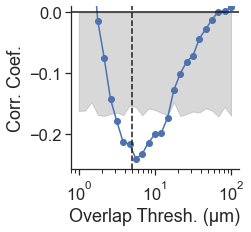

In [7]:
# Ext. Data. Fig. 6c Sweep overlap distance to see how it affects structure-function corr
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')
cn_type = 'I-E'

# sweepD dataframe is generated by sweep_overlap_d.py
with open(workingDir+'sweepD_pearson_'+cn_type+'_dir_cn_DF_PPC.pkl', 'rb') as f:  
    sweep_d = pickle.load(f)
max_dists = sweep_d['max_dists']
plt.plot(max_dists,sweep_d['corrs'],'-o')
#plt.plot(max_dists,sweep_d['shuf_low'],'--')
#plt.plot(max_dists,sweep_d['shuf_high'],'--')
if cn_type == 'E-I':
    plt.fill_between(max_dists, 0,sweep_d['shuf_high'], alpha=0.3, color='gray')
elif cn_type == 'I-E':
    plt.fill_between(max_dists, sweep_d['shuf_low'],0, alpha=0.3, color='gray')
plt.xscale('log')
plt.axhline(y=0, color='k')
plt.axvline(x=5, color='k', linestyle='--')
#plt.ylim([-1,1])
plt.xlabel('Overlap Thresh. (µm)')
plt.ylabel('Corr. Coef.')
#plt.title(cn_type)
sns.despine()

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim(ymin,0.01)

print(max_dists[sweep_d['corrs']>sweep_d['shuf_high']])
print(max_dists[sweep_d['corrs']<sweep_d['shuf_low']])
plt.savefig(figsDir+cn_type+'_d_sweep.pdf',bbox_inches='tight')

early: Data corr = -0.069, t-test p = 0.521
middle: Data corr = -0.046, t-test p = 0.644
late: Data corr = -0.227, t-test p = 0.021


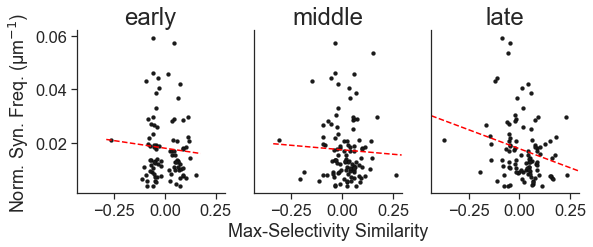

In [9]:
# ED Fig. 6d: PPC I2E syn density vs pair_select_idx by session groups 
sns.set(rc={'figure.figsize':(9,3)}, font_scale=1.5, style='ticks')
f, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, sharex=False, sharey=True)
plt.subplots_adjust(hspace = .4, wspace=0.2)
sessions = ['early','middle','late']
plot_dict = {}
for sess in sessions:
    with open(workingDir+'dir_cn_DF_'+sess+'_PPC.pkl', 'rb') as f:  
        dir_cn_DF= pickle.load(f)
    I2E_cn_DF = dir_cn_DF[dir_cn_DF.cn_type == 'I-E']
    # Remove one outlier in early and middle sessions
    I2E_cn_DF = I2E_cn_DF[I2E_cn_DF.syn_den < 0.1]
    I2E_cn_DF['log_syn_den'] = np.log10(I2E_cn_DF.syn_den.values)
    plot_dict[sess] = I2E_cn_DF

for idx,ax in enumerate((ax0, ax1, ax2)):
    (c,p) = figs.scatter(plot_dict[sessions[idx]], x='pair_select_idx_new', y='syn_den', sig_test='pearson',s=15, ax=ax)
    print(sessions[idx] + ': Data corr = %.3f, t-test p = %.3f' % (c,p))
    #ax.set_ylim([0, .07])
    #ax.set_xlim([-.33, .28])
    ax.set_title(sessions[idx], fontsize=24)
    if idx == 0:
        ax.set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')
    else:
        ax.get_yaxis().set_visible(False)
    if idx == 1:
        ax.set_xlabel('Max-Selectivity Similarity')
    else:
        ax.set_xlabel(None)
sns.despine()
for idx,ax in enumerate((ax0, ax1, ax2)):
    ax.set_xlim([np.min([ax0.get_xlim()[0],ax1.get_xlim()[0],ax2.get_xlim()[0]]),np.max([ax0.get_xlim()[1],ax1.get_xlim()[1],ax2.get_xlim()[1]])])
sns.despine()
plt.savefig(figsDir+'I2E_syn_den_vs_choice_sim_Sessions_datapoints.pdf',bbox_inches='tight')

n = 103 pairs
Data corr = -0.202
t-test p = 0.041


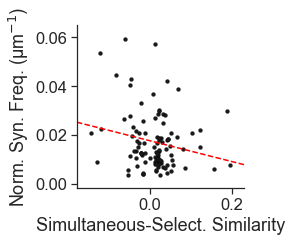

In [8]:
# Ext. Data Fig. 6e
# Syn Freq vs Simul-Select Sim

sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')
f,ax0 = plt.subplots(1, 1)

cn_type ='I-E' 
x = 'pair_select_idx_tmax_new'
y='syn_den'
with open(workingDir+'dir_cn_DF_PPC.pkl', 'rb') as f:  
            dir_cn_DF= pickle.load(f)

dir_cn_DF = dir_cn_DF[dir_cn_DF.cn_type==cn_type]
dir_cn_DF.dropna(subset=[x,y], inplace=True)

(c,p) = figs.scatter(dir_cn_DF, x=x, y=y, color='k',sig_test='pearson',s=15, ax=ax0)
print('n = %i pairs' % len(dir_cn_DF))
print('Data corr = %.3f' % c)
print('t-test p = %.3f' % p)

ax0.set_xlabel('Simultaneous-Select. Similarity')  
ax0.set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')

sns.despine()
plt.savefig(figsDir+cn_type+'_'+x+'_vs_'+y+'.pdf',bbox_inches='tight')

E-E
Data corr = -0.404
t-test p = 0.152
n = 14, shuf p = 0.070
E-I
Data corr = 0.654
t-test p = 0.001
n = 21, shuf p = 0.010
I-E
Data corr = -0.224
t-test p = 0.023
n = 103, shuf p = 0.000
I-I
Data corr = -0.365
t-test p = 0.300
n = 10, shuf p = 0.130


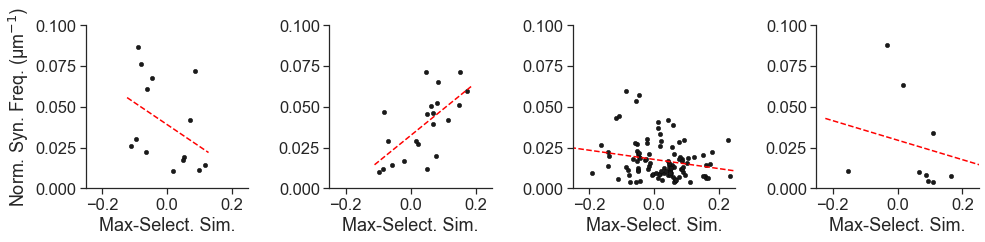

In [10]:
# ED Fig. 6f-i Syn Freq vs Select. Sim. Idx. for all cn types
sns.set(rc={'figure.figsize':(4*4,3)}, font_scale=1.5, style='ticks')
f, ax = plt.subplots(1, 4)
plt.subplots_adjust(hspace = 0, wspace=0.5)

dataset = 'PPC'
x = 'pair_select_idx_new'
y = 'syn_den'

n_shuf = 100
cn_types = ['E-E', 'E-I', 'I-E', 'I-I']

for i,cn_type in enumerate(cn_types):
    print(cn_type)
    if y == 'syn_den':
        with open(workingDir+'dir_cn_DF_'+dataset+'.pkl', 'rb') as f:  
            dir_cn_DF= pickle.load(f)
    elif y == 'psd_area':
        with open(workingDir+'dir_syn_DF_'+dataset+'.pkl', 'rb') as f:  
            dir_cn_DF= pickle.load(f)
    dir_cn_DF = dir_cn_DF[dir_cn_DF.cn_type==cn_type]
    (c,p) = figs.scatter(dir_cn_DF, x=x, y=y, color='k',sig_test='spearman',s=20, ax=ax[i])
    ax[i].set_xlabel('Max-Select. Sim.')  
    ax[i].set_xlim([-.25,.25])
    ax[i].set_ylim([0,.1])
    if i  == 0:
        ax[i].set_ylim([0,.1])
        ax[i].set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')
    else:
        ax[i].set_ylabel('')

    (shuf_df, scores) = figs.calc_shuffle_comparisons_new(dir_cn_DF, x=x, y=y, n_shuf=n_shuf)

    sns.despine()
plt.savefig(figsDir+'all_'+y+'_VS_'+x+'_'+dataset+'.pdf',bbox_inches='tight')

E-E
Data corr = 0.198
t-test p = 0.499
n = 14, shuf p = 0.307
E-I
Data corr = 0.561
t-test p = 0.002
n = 29, shuf p = 0.000
I-E
Data corr = 0.084
t-test p = 0.296
n = 156, shuf p = 0.143
I-I
Data corr = 0.092
t-test p = 0.754
n = 14, shuf p = 0.357


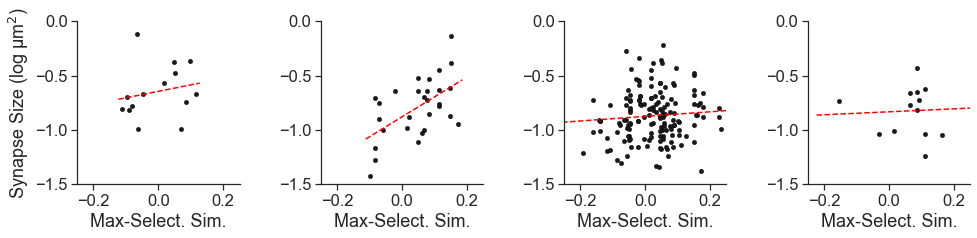

In [11]:
# ED Fig. 6j-k
# Syn Freq vs Select. Sim. Idx. for all cn types
sns.set(rc={'figure.figsize':(4*4,3)}, font_scale=1.5, style='ticks')
f, ax = plt.subplots(1, 4)
plt.subplots_adjust(hspace = 0, wspace=0.5)

dataset = 'PPC'
x = 'pair_select_idx_new'
y = 'log_psd_area'

n_shuf = 300
cn_types = ['E-E', 'E-I', 'I-E', 'I-I']

for i,cn_type in enumerate(cn_types):
    print(cn_type)
    if y == 'syn_den':
        with open(workingDir+'dir_cn_DF_'+dataset+'.pkl', 'rb') as f:  
            dir_cn_DF= pickle.load(f)
    elif y == 'log_psd_area':
        with open(workingDir+'dir_syn_DF_'+dataset+'.pkl', 'rb') as f:  
            dir_cn_DF= pickle.load(f)
    dir_cn_DF = dir_cn_DF[dir_cn_DF.cn_type==cn_type]

    (c,p) = figs.scatter(dir_cn_DF, x=x, y=y, color='k',sig_test='spearman',s=20, ax=ax[i])
    ax[i].set_xlim([-.25,.25])
    ax[i].set_ylim([-1.5,0])
    ax[i].set_xlabel('Max-Select. Sim.')  

    if i  == 0:
        ax[i].set_ylabel('Synapse Size (log µm$^2$)')
    else:
        ax[i].set_ylabel('')

    (shuf_df, scores) = figs.calc_shuffle_comparisons_new(dir_cn_DF, x=x, y=y, n_shuf=n_shuf)
    sns.despine()
plt.savefig(figsDir+'all_'+y+'_VS_'+x+'_'+dataset+'.pdf',bbox_inches='tight')